# experimental_preprocessing_techniques.ipynb

**Project**: Lumbar Spine Degenerative Classification  
**Description**: An experimental notebook for exploring preprocessing techniques in the Lumbar Spine Degenerative Classification project.

---

## Table of Contents
1. [Environment & Imports](#section1)
2. [Tensor Loading & Visualization](#section2)
3. [Image Filters & Enhancements](#section3)
4. [Example Usage](#section4)

---

<a id="section1"></a>
## 1. Environment & Imports

In [1]:
import os
import sys
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
from skimage.restoration import richardson_lucy
from skimage.filters import gaussian

# If this notebook is in the "notebooks" folder, adjust path to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

# Ensure we can import from "src" if not already on sys.path
module_path = os.path.abspath(os.path.join("src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data.ingest_data import load_config

print("Environment diagnostics:")
print(f"  Working directory : {os.getcwd()}")
print(f"  Python executable : {sys.executable}")

Environment diagnostics:
  Working directory : /home/jkskw/git/ml_lumbar_mri
  Python executable : /home/jkskw/git/ml_lumbar_mri/venv/bin/python


<a id="section2"></a>
## 2. Tensor Loading & Visualization

In [2]:
def visualize_tensor(path, limit=None):
    """
    Loads a PyTorch tensor from a file, displays its information,
    and visualizes its first `limit` slices.

    Parameters
    ----------
    path : str
        Path to the saved PyTorch tensor (.pt file).
    limit : int, optional
        Maximum number of slices to display. If None, display all slices.
    """
    # Load the tensor from file (with weights_only=True if your .pt uses it)
    tensor = torch.load(path, weights_only=True)

    print(f"Tensor loaded from: {path}")
    print(f"Shape: {tensor.shape}")
    print(f"Dtype: {tensor.dtype}")

    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().detach().numpy()

    if tensor.ndim < 3:
        raise ValueError("Tensor must have at least 3 dimensions: [D, H, W].")

    num_instances = tensor.shape[0]

    if limit is None:
        limit = num_instances
    else:
        limit = min(limit, num_instances)

    fig, axes = plt.subplots(1, limit, figsize=(limit * 3, 3))

    if limit == 1:
        axes = [axes]

    for i in range(limit):
        ax = axes[i]
        ax.imshow(tensor[i], cmap='gray')
        ax.set_title(f"Slice {i+1}")
        ax.axis("off")

    plt.show()

def tensor_to_numpy(path):
    """
    Loads a PyTorch tensor from a file and converts it to NumPy.

    Parameters
    ----------
    path : str
        Path to the saved PyTorch tensor (.pt file).

    Returns
    -------
    np.ndarray
        NumPy array representation of the tensor, shape [D, H, W].
    """
    tensor = torch.load(path, weights_only=True)
    volume_np = tensor.cpu().numpy()
    print(f"[INFO] Converted to NumPy from file: {path}")
    return volume_np

def visualize_numpy_slices(volume_np, limit=5, title_prefix=""):
    """
    Visualizes a 3D NumPy array (shape [D, H, W]) by plotting its first `limit` slices horizontally.

    Parameters
    ----------
    volume_np : np.ndarray
        Input array of shape [D, H, W].
    limit : int
        Number of slices to display.
    title_prefix : str
        Optional prefix for subplot titles.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D NumPy array [D, H, W].")

    num_slices = volume_np.shape[0]
    limit = min(limit, num_slices)

    fig, axes = plt.subplots(1, limit, figsize=(3 * limit, 3))
    if limit == 1:
        axes = [axes]

    for i in range(limit):
        axes[i].imshow(volume_np[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{title_prefix} Slice {i+1}")

    plt.show()

def visualize_two_tensors(path1, path2, title1="Tensor 1", title2="Tensor 2", limit=None, orientation="vertical"):
    """
    Loads two PyTorch tensors from files and visualizes their slices side by side.

    Parameters
    ----------
    path1 : str
        Path to the first .pt file.
    path2 : str
        Path to the second .pt file.
    title1 : str
        Title for the first tensor.
    title2 : str
        Title for the second tensor.
    limit : int, optional
        Max number of slices to display. If None, display up to min(#instances1,#instances2).
    orientation : str
        Either 'vertical' (slices stacked vertically) or 'horizontal' (stacked horizontally).
    """
    tensor1 = torch.load(path1, weights_only=True)
    tensor2 = torch.load(path2, weights_only=True)

    if isinstance(tensor1, torch.Tensor):
        tensor1 = tensor1.cpu().detach().numpy()
    if isinstance(tensor2, torch.Tensor):
        tensor2 = tensor2.cpu().detach().numpy()

    if tensor1.ndim < 3 or tensor2.ndim < 3:
        raise ValueError("Both tensors must have at least 3 dimensions [D, H, W].")

    num_instances1, num_instances2 = tensor1.shape[0], tensor2.shape[0]
    max_limit = min(num_instances1, num_instances2)
    if limit is None:
        limit = max_limit
    else:
        limit = min(limit, max_limit)

    if orientation == "vertical":
        fig, axes = plt.subplots(nrows=limit, ncols=2, figsize=(6, limit * 3))
    elif orientation == "horizontal":
        fig, axes = plt.subplots(nrows=2, ncols=limit, figsize=(limit * 3, 6))
    else:
        raise ValueError("Invalid orientation. Choose 'vertical' or 'horizontal'.")

    if limit == 1:
        if orientation == "vertical":
            axes = axes.reshape(1, 2)
        else:  # horizontal
            axes = axes.reshape(2, 1)

    for i in range(limit):
        if orientation == "vertical":
            axes[i, 0].imshow(tensor1[i], cmap='gray')
            axes[i, 0].set_title(f"{title1}")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(tensor2[i], cmap='gray')
            axes[i, 1].set_title(f"{title2}")
            axes[i, 1].axis("off")

        else:  # horizontal
            axes[0, i].imshow(tensor1[i], cmap='gray')
            axes[0, i].set_title(f"{title1}")
            axes[0, i].axis("off")

            axes[1, i].imshow(tensor2[i], cmap='gray')
            axes[1, i].set_title(f"{title2}")
            axes[1, i].axis("off")

    plt.show()

<a id="section3"></a>
## 3. Image Filters & Enhancements

In [3]:
def hist_equalization(volume_np: np.ndarray) -> np.ndarray:
    """
    Performs histogram equalization on each slice separately.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    eq_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        eq_slice = cv2.equalizeHist(slice_8u).astype(np.float32) / 255.0
        eq_slices.append(eq_slice)
    return np.stack(eq_slices, axis=0).astype(np.float32)

def clahe_enhancement(volume_np: np.ndarray, clip_limit=2.0, tile_grid_size=(8, 8)) -> np.ndarray:
    """
    Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to each slice.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    clahe_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        clahe_8u = clahe.apply(slice_8u)
        clahe_slice = clahe_8u.astype(np.float32) / 255.0
        clahe_slices.append(clahe_slice)
    return np.stack(clahe_slices, axis=0).astype(np.float32)

def median_blur_3d(volume_np: np.ndarray, ksize=3) -> np.ndarray:
    """
    Applies median blur on each 2D slice using cv2.medianBlur.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    blurred_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        mb_8u = cv2.medianBlur(slice_8u, ksize)
        mb_slice = mb_8u.astype(np.float32) / 255.0
        blurred_slices.append(mb_slice)
    return np.stack(blurred_slices, axis=0).astype(np.float32)

def unsharp_mask_3d(volume_np: np.ndarray, gaussian_ksize=(3,3), alpha=1.5, beta=-0.5) -> np.ndarray:
    """
    Applies an unsharp mask to each slice. Typically:
      sharpened = alpha*original + beta*blurred
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    sharpened_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        blurred_8u = cv2.GaussianBlur(slice_8u, gaussian_ksize, 0)
        sharpened_8u = cv2.addWeighted(slice_8u, alpha, blurred_8u, beta, 0)
        sharpened_slice = sharpened_8u.astype(np.float32) / 255.0
        sharpened_slices.append(sharpened_slice)
    return np.stack(sharpened_slices, axis=0).astype(np.float32)

def arithmetic_mean_3d(volume_np: np.ndarray, ksize=3) -> np.ndarray:
    """
    Applies a simple arithmetic mean (average) blur filter to each slice in the volume
    using cv2.blur with the specified ksize.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    out_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        blurred_8u = cv2.blur(slice_8u, (ksize, ksize))
        out_slice = blurred_8u.astype(np.float32) / 255.0
        out_slices.append(out_slice)
    return np.stack(out_slices, axis=0).astype(np.float32)

def min_filter_3d(volume_np: np.ndarray, ksize=3) -> np.ndarray:
    """
    Applies a min filter by morphological 'erode' on each 2D slice with a (ksize x ksize) kernel.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    kernel = np.ones((ksize, ksize), np.uint8)
    out_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        min_8u = cv2.erode(slice_8u, kernel)
        out_slice = min_8u.astype(np.float32)/255.0
        out_slices.append(out_slice)
    return np.stack(out_slices, axis=0).astype(np.float32)

def max_filter_3d(volume_np: np.ndarray, ksize=3) -> np.ndarray:
    """
    Applies a max filter by morphological 'dilate' on each 2D slice with a (ksize x ksize) kernel.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    kernel = np.ones((ksize, ksize), np.uint8)
    out_slices = []
    for slice_2d in volume_np:
        slice_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        max_8u = cv2.dilate(slice_8u, kernel)
        out_slice = max_8u.astype(np.float32)/255.0
        out_slices.append(out_slice)
    return np.stack(out_slices, axis=0).astype(np.float32)

def midpoint_filter_3d(volume_np: np.ndarray, ksize=3) -> np.ndarray:
    """
    Midpoint filter on each slice: out = (min_filter + max_filter) / 2.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    vol_min = min_filter_3d(volume_np, ksize=ksize)
    vol_max = max_filter_3d(volume_np, ksize=ksize)
    return (vol_min + vol_max) / 2.0

def proposed_mean_median_3d(volume_np: np.ndarray, ksize=3) -> np.ndarray:
    """
    Simple demonstration of combining median + mean in a local window:
    1) Compute median M of the window
    2) For each pixel p in the window, averageVal(p) = (p + M)/2
    3) Final center pixel = mean(averageVal(p) for all p in window)
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    out_slices = []
    pad = ksize // 2

    D, H, W = volume_np.shape
    for d in range(D):
        slice_2d = volume_np[d]
        norm_8u = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        slice_out = np.zeros_like(slice_2d, dtype=np.float32)

        for r in range(H):
            for c in range(W):
                rmin = max(0, r - pad)
                rmax = min(H, r + pad + 1)
                cmin = max(0, c - pad)
                cmax = min(W, c + pad + 1)

                patch = norm_8u[rmin:rmax, cmin:cmax].flatten()
                median_val = np.median(patch)
                patch_f = patch.astype(np.float32)
                avg_vals = (patch_f + median_val) / 2.0
                center_pix = avg_vals.mean()
                slice_out[r, c] = center_pix / 255.0

        out_slices.append(slice_out)

    return np.stack(out_slices, axis=0)

def adaptive_median_filter_3d(volume_np: np.ndarray, initial_ksize=3, max_ksize=7) -> np.ndarray:
    """
    Adaptive Median Filter on each slice. Grows window size up to max_ksize
    if the median is not in (z_min, z_max). Commonly known as 'AMF'.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array [D, H, W].")

    D, H, W = volume_np.shape
    output_slices = []

    for d in range(D):
        slice_in = volume_np[d]
        slice_out = np.zeros_like(slice_in, dtype=np.float32)
        norm_8u = cv2.normalize(slice_in, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        for r in range(H):
            for c in range(W):
                k = initial_ksize
                pixel_val = norm_8u[r, c]
                while True:
                    half = k // 2
                    rmin = max(0, r - half)
                    rmax = min(H, r + half + 1)
                    cmin = max(0, c - half)
                    cmax = min(W, c + half + 1)

                    patch = norm_8u[rmin:rmax, cmin:cmax].flatten()
                    z_min = np.min(patch)
                    z_max = np.max(patch)
                    z_med = np.median(patch)

                    A1 = z_med - z_min
                    A2 = z_med - z_max

                    # Stage A
                    if A1 > 0 and A2 < 0:
                        # median is valid
                        B1 = pixel_val - z_min
                        B2 = pixel_val - z_max
                        if B1 > 0 and B2 < 0:
                            # keep original
                            slice_out[r, c] = pixel_val / 255.0
                        else:
                            # replace with median
                            slice_out[r, c] = z_med / 255.0
                        break
                    else:
                        k += 2
                        if k > max_ksize:
                            # forced to use median
                            slice_out[r, c] = z_med / 255.0
                            break
        output_slices.append(slice_out)

    return np.stack(output_slices, axis=0)


def richardson_lucy_3d(volume_np: np.ndarray, psf: np.ndarray, iterations: int = 20) -> np.ndarray:
    """
    Applies Richardson–Lucy deconvolution to each 2D slice in the volume.
    This function leverages scikit-image's 'richardson_lucy' method.

    volume_np : shape [D, H, W], float in [0,1].
    psf       : shape [Hpsf, Wpsf], also normalized inside the function.
    """
    if volume_np.ndim != 3:
        raise ValueError("Expected 3D array.")
    if psf.ndim != 2:
        raise ValueError("PSF must be 2D.")

    psf = psf / np.sum(psf)  # normalize
    deconvolved_slices = [richardson_lucy(slice_2d, psf, num_iter=iterations) for slice_2d in volume_np]
    return np.stack(deconvolved_slices, axis=0).astype(np.float32)

<a id="section4"></a>
## 4. Example Usage
Example code that picks a `.pt` file, loads it, visualizes slices, applies various filters and normalizations, and displays the results side by side.

Tensor loaded from: data/interim/target_window_128x128_3D_B1A1/scs/4003253.pt
Shape: torch.Size([3, 128, 128])
Dtype: torch.float32


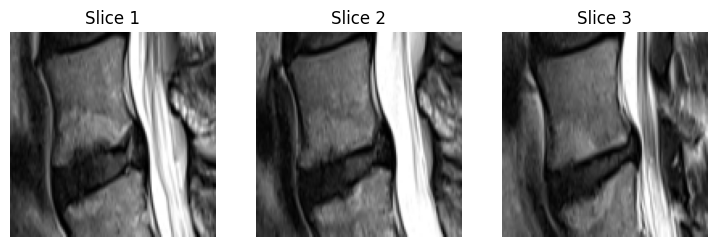

[INFO] Converted to NumPy from file: data/interim/target_window_128x128_3D_B1A1/scs/4003253.pt


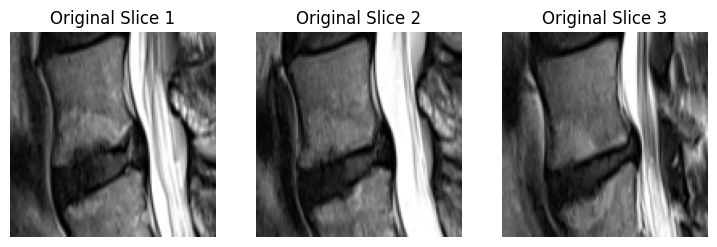

Comparing two tensors:


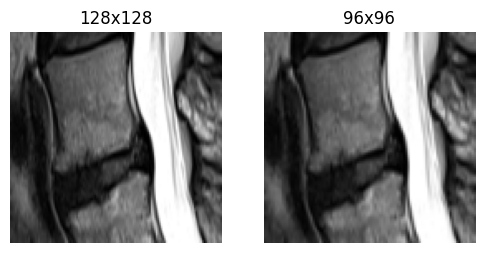

Applying filters and enhancements:


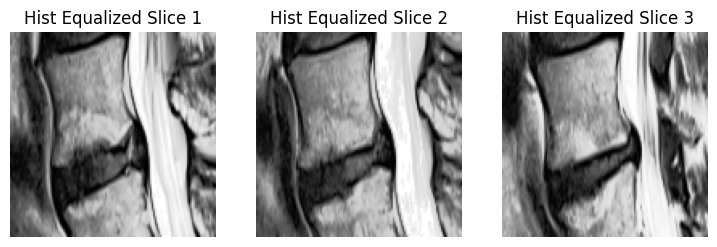

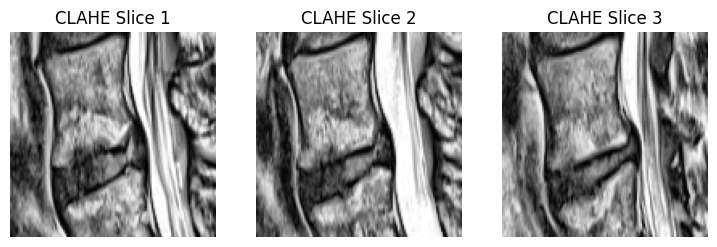

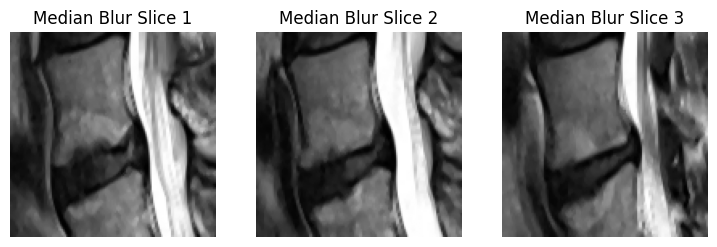

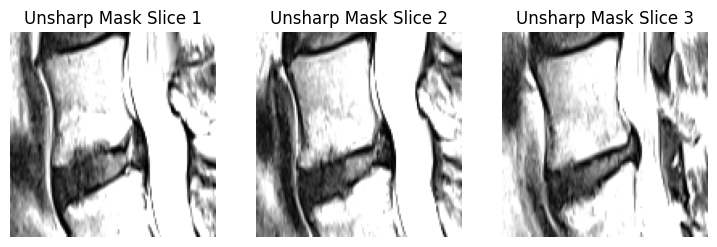

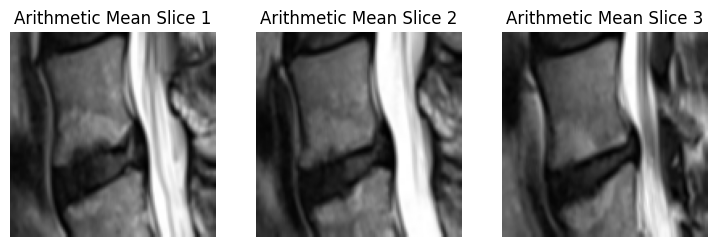

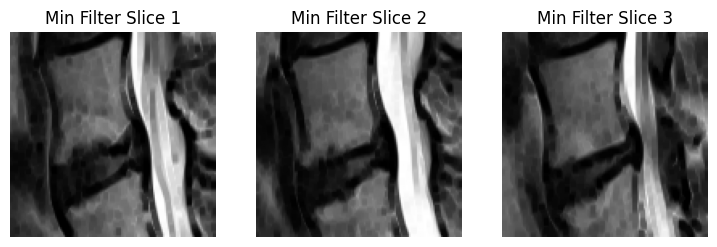

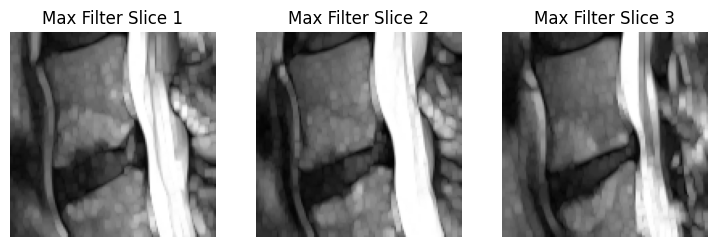

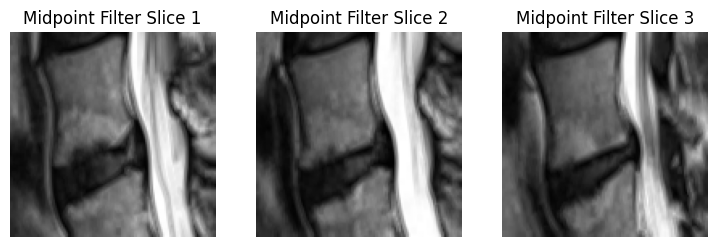

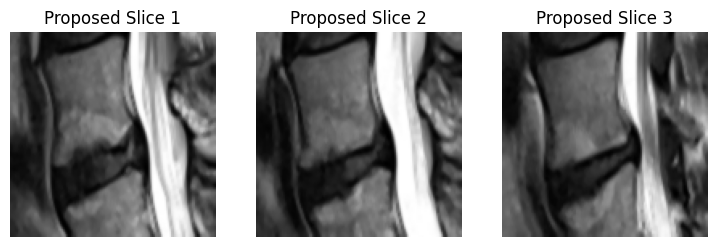

/tmp/ipykernel_28103/342675795.py:189: RuntimeWarning: overflow encountered in scalar subtract
  B2 = pixel_val - z_max


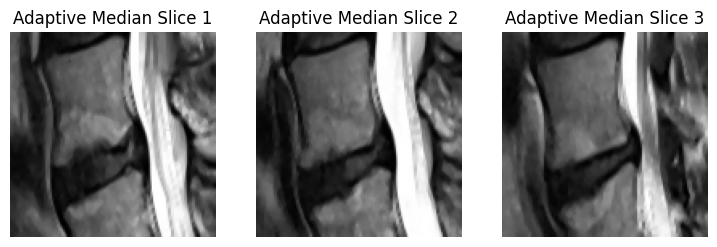

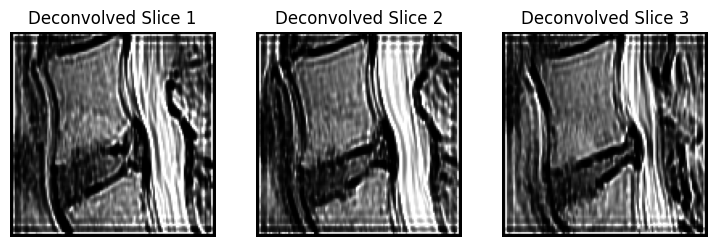

In [14]:
# Example path to a tensor file
TENSOR_PATH = "data/interim/target_window_128x128_3D_B1A1/scs/4003253.pt"

SLICE_LIMIT = 15

# 1) Quick single-tensor visualization
visualize_tensor(TENSOR_PATH, limit=SLICE_LIMIT)

# 2) Convert to NumPy and show
volume_np = tensor_to_numpy(TENSOR_PATH)
visualize_numpy_slices(volume_np, limit=SLICE_LIMIT, title_prefix="Original")

# 3) Compare two tensors side by side
PATH1 = "/home/jkskw/git/ml_lumbar_mri/data/interim/full_series_128x128_1D/scs/4003253.pt"
PATH2 = "/home/jkskw/git/ml_lumbar_mri/data/interim/full_series_96x96_1D/scs/4003253.pt"

print("Comparing two tensors:")
visualize_two_tensors(PATH1, PATH2, title1="128x128", title2="96x96", limit=5, orientation="vertical")

# 4) Apply various filters and show
print("Applying filters and enhancements:")

hist_eq_vol = hist_equalization(volume_np)
visualize_numpy_slices(hist_eq_vol, limit=SLICE_LIMIT, title_prefix="Hist Equalized")

clahe_vol = clahe_enhancement(volume_np, clip_limit=3, tile_grid_size=(8,8))
visualize_numpy_slices(clahe_vol, limit=SLICE_LIMIT, title_prefix="CLAHE")

median_vol = median_blur_3d(volume_np, ksize=3)
visualize_numpy_slices(median_vol, limit=SLICE_LIMIT, title_prefix="Median Blur")

unsharp_vol = unsharp_mask_3d(volume_np, gaussian_ksize=(3,3), alpha=3, beta=-0.5)
visualize_numpy_slices(unsharp_vol, limit=SLICE_LIMIT, title_prefix="Unsharp Mask")

mean_linear = arithmetic_mean_3d(volume_np, ksize=3)
visualize_numpy_slices(mean_linear, limit=SLICE_LIMIT, title_prefix="Arithmetic Mean")

min_vol = min_filter_3d(volume_np, ksize=3)
visualize_numpy_slices(min_vol, limit=SLICE_LIMIT, title_prefix="Min Filter")

max_vol = max_filter_3d(volume_np, ksize=3)
visualize_numpy_slices(max_vol, limit=SLICE_LIMIT, title_prefix="Max Filter")

midpoint_vol = midpoint_filter_3d(volume_np, ksize=3)
visualize_numpy_slices(midpoint_vol, limit=SLICE_LIMIT, title_prefix="Midpoint Filter")

proposed_vol = proposed_mean_median_3d(volume_np, ksize=3)
visualize_numpy_slices(proposed_vol, limit=SLICE_LIMIT, title_prefix="Proposed")

amf_result = adaptive_median_filter_3d(volume_np, initial_ksize=3, max_ksize=7)
visualize_numpy_slices(amf_result, limit=SLICE_LIMIT, title_prefix="Adaptive Median")

# Example of Richardson-Lucy deconvolution
psf = gaussian(np.ones((5, 5)), sigma=1)  # Construct a simple Gaussian kernel
deconvolved_volume = richardson_lucy_3d(volume_np, psf, iterations=30)
visualize_numpy_slices(deconvolved_volume, limit=5, title_prefix="Deconvolved")